# GIK2NX - Assignment 1 - Group 7

Authors:

  - Sebastian Danielsson
  - Jesper Andersson
  - Veronika Engberg

## Simulation 1

In [74]:
import numpy as np
import random
import mesa
import matplotlib.pyplot as plt

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.remove(self)

        # Filter out cellmates with equal or more wealth
        poorer_cellmates = [cellmate for cellmate in cellmates if cellmate.wealth < self.wealth]

        if poorer_cellmates:
            # Select the cellmate with the least wealth
            min_wealth_cellmate = min(poorer_cellmates, key=lambda cellmate: cellmate.wealth)
            min_wealth_cellmate.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height, min_wealth, max_wealth):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            a.wealth = random.randint(min_wealth, max_wealth)  # Comment out to restore money_agent.ipynb behaviour
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


Run with distribution of wealth between 0-5

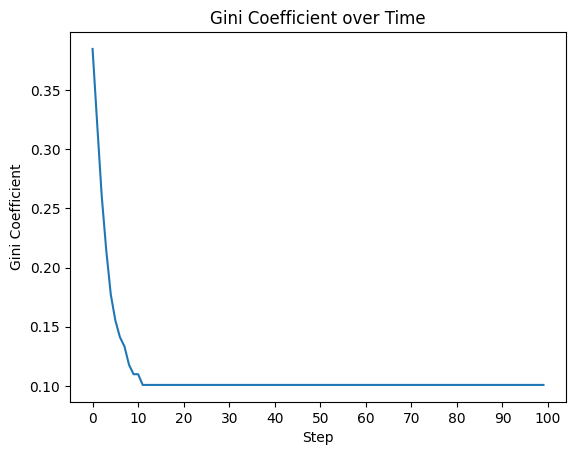

In [75]:
steps = 100
width = 10
height = 10
min_wealth = 0
max_wealth = 5

model = MoneyModel(steps, width, height, min_wealth, max_wealth)
for i in range(steps):
    model.step()

# Plot the Gini coefficient over time
gini = model.datacollector.get_model_vars_dataframe()
plt.plot(gini)
plt.title("Gini Coefficient over Time")
plt.xlabel("Step")
plt.ylabel("Gini Coefficient")
plt.xticks(np.arange(0, 100.1, 10))
plt.show()


Run with distribution of wealth between 0-20

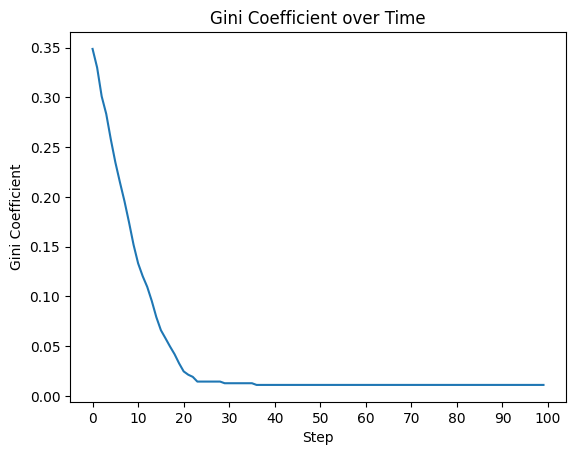

In [76]:
steps = 100
width = 10
height = 10
min_wealth = 0
max_wealth = 20

model = MoneyModel(steps, width, height, min_wealth, max_wealth)
for i in range(steps):
    model.step()

# Plot the Gini coefficient over time
gini = model.datacollector.get_model_vars_dataframe()
plt.plot(gini)
plt.title("Gini Coefficient over Time")
plt.xlabel("Step")
plt.ylabel("Gini Coefficient")
plt.xticks(np.arange(0, steps+1, 10))
plt.show()


## Simulation 2

In [77]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from IPython.display import Video

class CarAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.parked = False
        self.steps_to_park = 0
        self.parking_time = random.randint(3, 5)
        self.successfully_parked = False

    def move(self):
        # Get all possible steps
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)

        # Check for available parking spaces in the possible steps
        available_parking_spaces = []
        for pos in possible_steps:
            this_cell = self.model.grid.get_cell_list_contents([pos])
            for agent in this_cell:
                if isinstance(agent, ParkingSpaceAgent) and not agent.occupied:
                    available_parking_spaces.append(pos)
        
        # If there are available parking spaces, move to one of them
        if available_parking_spaces:
            new_position = random.choice(available_parking_spaces)
        else:
            # Otherwise, move randomly
            new_position = random.choice(possible_steps)

        self.model.grid.move_agent(self, new_position)

    def step(self):
        if not self.parked:
            self.move()
            self.steps_to_park += 1
            this_cell = self.model.grid.get_cell_list_contents([self.pos])
            for agent in this_cell:
                if isinstance(agent, ParkingSpaceAgent) and not agent.occupied:
                    self.parked = True
                    self.successfully_parked = True
                    agent.occupy(self)
        elif self.parked:
            self.parking_time -= 1
        # Collect data for every car at every step
        self.model.datacollector.collect(self.model)

    def try_leaving(self):
        if self.parked and self.parking_time <= 0:
            self.parked = False
            parking_space = self.model.grid.get_cell_list_contents([self.pos])[0]
            parking_space.vacate()
            self.model.datacollector.collect(self.model)
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

class ParkingSpaceAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.occupied = False
        self.car = None

    def occupy(self, car):
        self.occupied = True
        self.car = car

    def vacate(self):
        self.occupied = False
        self.car = None

    def step(self):
        if self.occupied and self.car:
            self.car.try_leaving()

class ParkingLotModel(Model):
    def __init__(self, size, num_cars, num_parking_spaces):
        self.grid = MultiGrid(size, size, False)
        self.schedule = RandomActivation(self)
        self.grid_states = []
        self.datacollector = DataCollector(
            agent_reporters={"StepsToPark": "steps_to_park", "SuccessfullyParked": "successfully_parked"}
        )

        car_agent_id = 0
        parking_space_agent_id = 1000

        # Systematically create parking spaces along the bottom edge and then the right edge
        parking_spaces_created = 0
        # First, fill the bottom edge
        for x in range(size):
            if parking_spaces_created < num_parking_spaces:
                agent = ParkingSpaceAgent(parking_space_agent_id, self)
                self.grid.place_agent(agent, (x, size-1))
                self.schedule.add(agent)
                parking_space_agent_id += 1
                parking_spaces_created += 1
            else:
                break

        # If needed, fill the right edge
        for y in range(size - 2, -1, -1):  # start from second last row to avoid corner double allocation
            if parking_spaces_created < num_parking_spaces:
                agent = ParkingSpaceAgent(parking_space_agent_id, self)
                self.grid.place_agent(agent, (size-1, y))
                self.schedule.add(agent)
                parking_space_agent_id += 1
                parking_spaces_created += 1
            else:
                break

        # Create cars
        for _ in range(num_cars):
            car = CarAgent(car_agent_id, self)
            self.grid.place_agent(car, (0, 0))
            self.schedule.add(car)
            car_agent_id += 1

    def get_grid_state(self):
        grid_state = np.zeros((self.grid.width, self.grid.height))
        for agent in self.schedule.agents:
            if isinstance(agent, ParkingSpaceAgent):
                x, y = agent.pos
                grid_state[x, y] = 1 if agent.occupied else 3

        for agent in self.schedule.agents:
            if isinstance(agent, CarAgent):
                x, y = agent.pos
                if grid_state[x, y] not in [1, 3]:
                    grid_state[x, y] = 2
        return grid_state

    def step(self):
        self.schedule.step()
        self.grid_states.append(self.get_grid_state())

# Run the model function
def runModel(num_steps, size, num_cars, num_parking_spaces):
    model = ParkingLotModel(size, num_cars, num_parking_spaces)
    for i in range(num_steps):
        model.step()
    return model

# Plot data function
def plotData(data, num_steps):
    car_data = data[data.index.get_level_values('AgentID') < 1000]
    steps_to_park_data = car_data.groupby('AgentID')['StepsToPark'].max()
    successfully_parked_data = car_data.groupby('AgentID')['SuccessfullyParked'].max()

    colors = ['red' if not parked else 'blue' for parked in successfully_parked_data.values]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(steps_to_park_data.index, steps_to_park_data.values, color=colors)
    plt.xlabel('Car Agent ID')
    plt.ylabel('Steps to Park')
    plt.title('Number of Steps Each Car Took to Park (Red indicates not parked)')
    plt.xticks(steps_to_park_data.index)
    plt.yticks(np.arange(0, num_steps+1, num_steps/10))
    plt.tight_layout()
    plt.show()

# Generate video of each step
def generate_video(model, filename):
    cmap = ListedColormap(['white', 'red', 'blue', 'green'])

    fig, ax = plt.subplots(figsize=(5, 5))

    def animate(i):
        ax.clear()
        ax.imshow(model.grid_states[i], cmap=cmap, interpolation='nearest')
        ax.set_title(f"Step {i+1}")
        ax.set_xticks(range(size))
        ax.set_yticks(range(size))

    ani = animation.FuncAnimation(fig, animate, frames=len(model.grid_states), interval=1000)
    ani.save(filename, writer='ffmpeg')
    plt.close()


Run 1: Size 8x8, 10 cars, 5 parking spaces, 20 steps

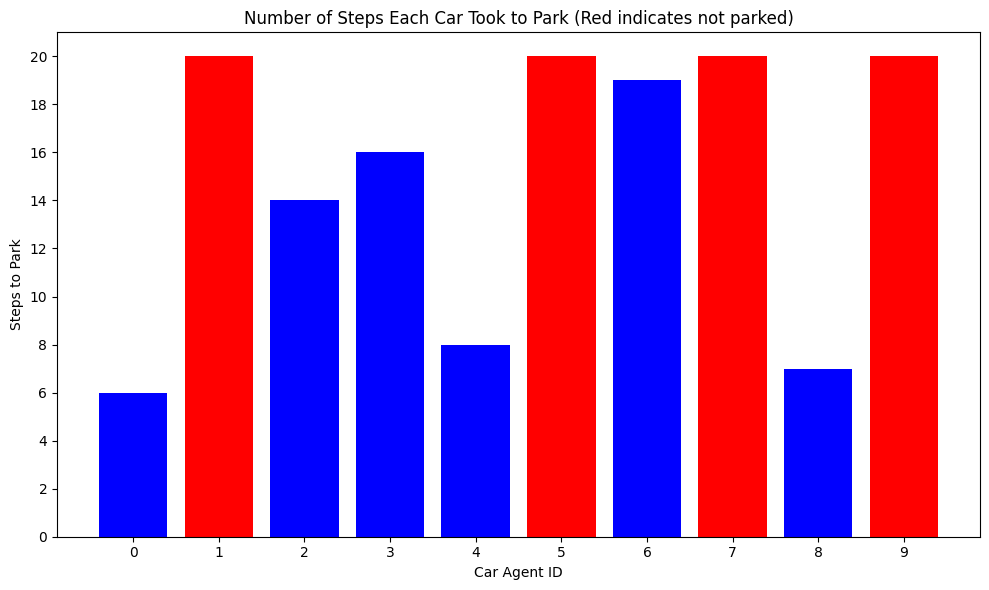

In [83]:
# Configure the model
num_steps = 20
num_cars = 10
num_parking_spaces = 5
size = 5

# Create the model
model = runModel(num_steps, size, num_cars, num_parking_spaces)
data = model.datacollector.get_agent_vars_dataframe()

plotData(data, num_steps)

# Generate a video of the simulation
filename = 'simulation2_run1.mp4'
generate_video(model, filename)

# Show the video
Video(filename, embed=True)


Run 2: Size 8x8, 20 cars, 5 parking spaces, 20 steps

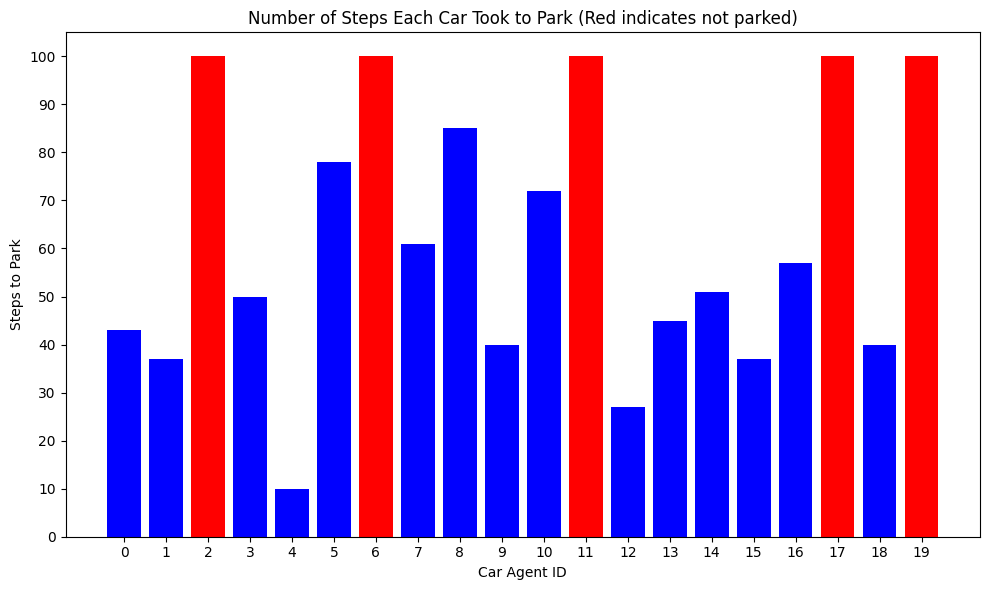

In [79]:
# Configure the model
num_steps = 100
num_cars = 20
num_parking_spaces = 5
size = 8

# Create the model
model = runModel(num_steps, size, num_cars, num_parking_spaces)
data = model.datacollector.get_agent_vars_dataframe()

plotData(data, num_steps)

# Generate a video of the simulation
filename = 'simulation2_run2.mp4'
generate_video(model, filename)

# Show the video
Video(filename, embed=True)
